# Master model development

## John Brandt

### Last updated: Feb 4 2019

*  Package loading
*  Hyperparameter definitions
*  Additional layer definitions
*  Model definition
*  Data loading
*  Data preprocessing
*  K means clustering
*  Augment training data
*  Loss definition
*  Equibatch creation
*  Model training
*  Model validation and sanity checks

# Experiment log
*  Baseline - Bilinear up/downsample separate for 10, 20m bands, no superresolution
*  Bilinear up/downsample for 10m bands, nearest upsample for 20m bands to 10m
*  Nearest up/downsample for all bands, no superresolution
*  Bicubic up/downsample for all bands, no superresolution
*  Bicubic up/downsample separate for 10, 20m bands, no superresolution
*  Above w/ superresolution

In [1]:
#TODO Remove imports that aren't needed to save RAM
from tqdm import tqdm_notebook, tnrange
import tensorflow as tf

sess = tf.Session()
from keras import backend as K
K.set_session(sess)

import keras
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers import ELU
from keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.layers import Conv2D, Lambda, Dense, Multiply, Add, Bidirectional, ConvLSTM2D
from tensorflow.python.keras.activations import selu
from tensorflow.initializers import glorot_normal, lecun_normal

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import conv2d

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import itertools
from tflearn.layers.conv import global_avg_pool
from tensorflow.contrib.framework import arg_scope
from keras.regularizers import l1
from tensorflow.layers import batch_normalization
from tensorflow.python.util import deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [2]:
%run ../src/zoneout.py
%run ../src/convgru.py
%run ../src/lovasz.py
%run ../src/utils.py
%run ../src/adabound.py
%run ../src/slope.py
%run ../src/dropblock.py

# Hyperparameter definitions

In [3]:
ZONE_OUT_PROB = 0.3
L2_REG = 0.0
INITIAL_LR = 2e-4
FINAL_LR = 1e-3
BN_MOMENTUM = 0.9
BATCH_SIZE = 16
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
MAX_DROPBLOCK = 0.85

gru_flt = 32
fpa_flt = 32
out_conv_flt = 32


AUGMENTATION_RATIO = 4
IMAGE_SIZE = 16
LABEL_SIZE = 14


# Additional layer definitions

Some of these may be able to be removed, or moved to a src/*.py

*  Conv SELU
*  Conv BN ELU
*  Feature pyramid attention (with downsample / upsample)
*  Feature pyramid attention (w/o downsample / upsample)
*  Temporal attention
*  CSE, SSE, cCSE
*  Reflection padding


In [4]:
def conv_bn_elu(inp, is_training, kernel_size, scope,
                filter_count = 16, pad = True, padding = 'valid', dilated = False,
                activation = True):
    if activation:
        act = selu
    else:
        act = None
    print(act)
    if not dilated:
        padded = ReflectionPadding2D((1, 1,))(inp)
        conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size), activation = act,
                        padding = padding, kernel_initializer = lecun_normal())(padded)
    if not dilated and not pad:
        conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size), activation = act,
                        padding = padding, kernel_initializer = lecun_normal())(inp)
    if dilated:
        padded = ReflectionPadding2D((2, 2,))(inp)
        conv = Conv2D(filters = filter_count, kernel_size = (3, 3), activation = act, dilation_rate = (2, 2),
                        padding = padding, kernel_initializer = lecun_normal())(padded)
    return conv

def conv_bn_relu(inp, is_training, kernel_size, scope, filters, activation = True, use_bias = False):
    
    conv = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size), activation = None,
                  padding = 'valid', use_bias = use_bias,
                  kernel_initializer = tf.keras.initializers.he_normal())(inp)
    
    bn = Batch_Normalization(conv, is_training, scope)
    if activation:
        bn = tf.nn.relu(bn)

    return bn
    
def fpa(inp, is_training, filter_count):
    #one = conv_bn_elu(inp, is_training, 1, 'forward1', filter_count, False, 'valid', False, False)
    #five = conv_bn_elu(inp, is_training, 5, 'down1', filter_count, False, 'valid', False, True)
    #five_f = conv_bn_elu(five, is_training, 5, 'down1_f', filter_count, False, 'valid', False, False)
    #three = conv_bn_elu(five, is_training, 3, 'down2', filter_count, False, 'valid', False, True)
    #three_f = conv_bn_elu(three, is_training, 3, 'down2_f', filter_count, False, 'valid', False, False)
    
    one = conv_bn_relu(inp, is_training, 1, 'forward1', filter_count, False)
    five = conv_bn_relu(inp, is_training, 5, 'down1', filter_count, True)
    five_f = conv_bn_relu(five, is_training, 5, 'down1_f', filter_count, False)
    three = conv_bn_relu(five, is_training, 3, 'down2', filter_count, True)
    three_f = conv_bn_relu(three, is_training, 3, 'down2_f', filter_count, False)
    
    
    three_up = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'bilinear')(three_f)
    #three_up = get_deconv2d(three_f, filter_count, filter_count, 'three_up', is_training)
    three_up = tf.nn.relu(three_up)
    five_up = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'bilinear')(five_f)
    #five_up = get_deconv2d(five_f, filter_count, filter_count, 'five_up', is_training)
    five_up = tf.nn.relu(five_up)
    
    print("One: {}".format(one.shape))
    print("Five: {}".format(five.shape))
    print("Five_F: {}".format(five_f.shape))
    print("Three: {}".format(three.shape))
    print("Three_f: {}".format(three_f.shape))
    print("Three_up: {}".format(three_up.shape))
    print("Five_up: {}".format(five_up.shape))
    
    # top block
    #pooled = tf.keras.layers.GlobalAveragePooling2D()(inp)
    #one_top = conv_bn_elu(tf.reshape(pooled, (-1, 1, 1, pooled.shape[-1])),
    #                      is_training, 1, 'top1', filter_count, pad = False)
    #four_top = tf.keras.layers.UpSampling2D((16, 16))(one_top)
    #rint("Sixteen top: {}".format(four_top.shape))
    
    
    concat_1 = tf.nn.relu(tf.multiply(one, tf.nn.relu(tf.add(three_up, five_up))))
    #concat_2 = tf.add(concat_1, four_top)
    print("Feature pyramid attention shape {}".format(concat_1.shape))
    return concat_1
    
def create_deconv_init(filter_size, num_channels):
    bilinear_kernel = np.zeros([filter_size, filter_size], dtype=np.float32)
    scale_factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = scale_factor - 1
    else:
        center = scale_factor - 0.5
    for x in range(filter_size):
        for y in range(filter_size):
            bilinear_kernel[x,y] = (1 - abs(x - center) / scale_factor) * \
                                   (1 - abs(y - center) / scale_factor)
    weights = np.zeros((filter_size, filter_size, num_channels, num_channels))
    for i in range(num_channels):
        weights[:, :, i, i] = bilinear_kernel

    #assign numpy array to constant_initalizer and pass to get_variable
    bilinear_init = tf.constant_initializer(value=weights, dtype=tf.float32)
    return bilinear_init



In [5]:

def get_deconv2d(inp, filter_count, num_channels, scope, is_training):
    bilinear_init = create_deconv_init(4, filter_count)
    x = tf.keras.layers.Conv2DTranspose(filters = filter_count, kernel_size = (4, 4),
                                        strides=(2, 2), padding='same', 
                                        use_bias = False,
                                        kernel_initializer = bilinear_init)(inp)
    #x = ELU()(x)
    #x = tf.nn.relu(x)
    x = Batch_Normalization(x, training=is_training, scope = scope + "bn")
    return x


def Batch_Normalization(x, training, scope):
    return batch_normalization(inputs=x, 
                               momentum = BN_MOMENTUM, 
                               training=training,
                               renorm = True,
                               reuse=None,
                               name = scope)

def temporal_attention(inp, units):
    # This rescales each output
    # Timesteps that are more important get weighted higher
    # Timesteps that are least important get weighted lower --> B, N, H, W, C
    conved = TimeDistributed(Conv2D(units, (1, 1), padding = 'same', kernel_initializer = 'glorot_uniform',
                            activation = 'tanh', strides = (1, 1)))(inp)
    
    
    #conved = tf.reshape(conved, (-1, units, 16, 16, STEPS))
    print("Attention weight shape: {}".format(conved.shape))
    conved = TimeDistributed(Conv2D(1, (1, 1), padding = 'same', kernel_initializer = 'glorot_uniform',
                            activation = 'sigmoid', use_bias = False, strides = (1, 1)))(conved)
    print("Conved sigmoid shape: {}".format(conved.shape))
    #conved = tf.reshape(conved, (-1, 24, 1, 1, 1))
    
    alphas = tf.reduce_sum(conved, axis = 1, keep_dims = True)
    print("Attention alphas: {}".format(alphas.shape))
    # We need to calculate the total sum for each pixel for each channel, so that we can combine them
    alphas = conved / alphas
    print("Attention weight shapes {}".format(alphas.shape))
    
    # This actually multiplies the Conv by the input
    multiplied = tf.reduce_sum(alphas * inp, axis = 1)
    return multiplied

In [6]:
def cse_block(prevlayer, prefix):
    mean = Lambda(lambda xin: K.mean(xin, axis=[1, 2]))(prevlayer)
    lin1 = Dense(K.int_shape(prevlayer)[3] // 2, name=prefix + 'cse_lin1', activation='relu')(mean)
    lin2 = Dense(K.int_shape(prevlayer)[3], name=prefix + 'cse_lin2', activation='sigmoid')(lin1)
    x = Multiply()([prevlayer, lin2])
    return x


def sse_block(prevlayer, prefix):
    conv = Conv2D(1, (1, 1), padding="same", kernel_initializer="glorot_uniform",
                  activation='sigmoid', strides=(1, 1),
                  name=prefix + "_conv")(prevlayer)
    conv = Multiply(name=prefix + "_mul")([prevlayer, conv])
    return conv


def csse_block(x, prefix):
    '''
    Implementation of Concurrent Spatial and Channel ‘Squeeze & Excitation’ in Fully Convolutional Networks
    https://arxiv.org/abs/1803.02579
    '''
    cse = cse_block(x, prefix)
    sse = sse_block(x, prefix)
    x = Add(name=prefix + "_csse_mul")([cse, sse])

    return x

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')
    
def gru_block(inp, length, size, flt, scope, train, normalize = True):
    with tf.variable_scope(scope):
        print("GRU input shape {}, zoneout: {}".format(inp.shape, ZONE_OUT_PROB))
        cell_fw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, fpa = True)
        cell_bw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, fpa = True)
        cell_fw = ZoneoutWrapper(
           cell_fw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        cell_bw = ZoneoutWrapper(
            cell_bw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        steps, out = convGRU(inp, cell_fw, cell_bw, length)
        gru = tf.concat(out, axis = -1)
        steps = tf.concat(steps, axis = -1)
        print("Down block output shape {}".format(gru.shape))
    return gru, steps


# Model definition

## Placeholders

In [7]:
n_bands = 16
reg = keras.regularizers.l2(L2_REG) # for GRU
inp = tf.placeholder(tf.float32, shape=(None, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands))
length = tf.placeholder(tf.int32, shape = (None, 1))
labels = tf.placeholder(tf.float32, shape=(None, 14, 14))#, 1))
keep_rate = tf.placeholder_with_default(1.0, ()) # For DropBlock
length2 = tf.reshape(length, (-1,)) # Remove
is_training = tf.placeholder_with_default(False, (), 'is_training') # For BN, DropBlock
alpha = tf.placeholder(tf.float32, shape = ()) # For loss scheduling

## Layers

In [8]:
# Unsure if this block is better replaced by 1x1 ConvGRU output
#stacked = tf.reshape(inp, (-1, 16, 16, n_bands*24))
#pixel_information = Conv2D(filters = gru_flt, kernel_size = (1, 1),
#            padding = 'valid', activation = selu, kernel_initializer = lecun_normal())(stacked)
    
# 3 x 3 GRU

inp_first_half = inp[:, :, :, :, :10]
inp_second_half = inp[:, :, :, :, 11:]
no_dem = tf.concat([inp_first_half, inp_second_half], axis = -1)
dem = tf.reshape(tf.reduce_mean(inp[:, :, :, :, 10], axis = 1), (-1, 16, 16, 1))
gru_out, steps = gru_block(inp = no_dem, length = length2, 
                            size = [16, 16], 
                            flt = gru_flt, 
                            scope = 'down_16', 
                            train = is_training)


gru_out = tf.concat([gru_out, dem], axis = -1)
csse1 = csse_block(gru_out, 'csse1')
drop_block1 = DropBlock2D(keep_prob=keep_rate, block_size=5)
csse1 = drop_block1(csse1, is_training)

# Light FPA, CSSE, 4x4 Drop block
fpa1 = fpa(csse1, is_training, fpa_flt)
csse2 = csse_block(fpa1, 'csse2')
drop_block2 = DropBlock2D(keep_prob=keep_rate, block_size=4)
csse2 = drop_block2(csse2, is_training)


# Skip connect
x = tf.concat([csse2, csse1], axis = -1)

# Conv SELU, 16x16 - 14x14



x = conv_bn_elu(x, is_training, 3, "out_2", out_conv_flt, False, 'valid')
#x = conv_bn_relu(x, is_training, 3, 'out_2', out_conv_flt, False)

print("Initializing last sigmoid bias with -2.94 constant")
init = tf.constant_initializer([-np.log(0.7/0.3)]) # For focal loss
fm = Conv2D(filters = 1,
            kernel_size = (1, 1), 
            padding = 'valid',
            activation = 'sigmoid',
            bias_initializer = init,
           )(x) # For focal loss

GRU input shape (?, 24, 16, 16, 15), zoneout: 0.3
(3, 3, 47, 64)
(1, 1, 64, 1)
(?, 16, 16, 64)
(3, 3, 47, 64)
(1, 1, 64, 1)
(?, 16, 16, 64)
Down block output shape (?, 16, 16, 64)
One: (?, 16, 16, 32)
Five: (?, 12, 12, 32)
Five_F: (?, 8, 8, 32)
Three: (?, 10, 10, 32)
Three_f: (?, 8, 8, 32)
Three_up: (?, 16, 16, 32)
Five_up: (?, 16, 16, 32)
Feature pyramid attention shape (?, 16, 16, 32)
<function selu at 0x1221c1a60>
Initializing last sigmoid bias with -2.94 constant


In [9]:
total_parameters = 0
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
print("This model has {} parameters".format(total_parameters))

This model has 241621 parameters


# Data loading

*  Load in CSV data from Collect Earth
*  Reconstruct the X, Y grid for the Y data per sample
*  Calculate NDVI, EVI, SAVI, BI, MSAVI2, and SI
*  Stack X, Y, length data
*  Apply median filter to DEM

In [10]:
data_x = np.load("../tile_data/processed/data_x_l2a_processed.npy")
data_y = np.load("../tile_data/processed/data_y_l2a_processed.npy")
lengths = np.load("../tile_data/processed/length_l2a_processed.npy")

data_x = np.delete(data_x, 14, -1) 
#data_x = np.delete(data_x, 13, -1)

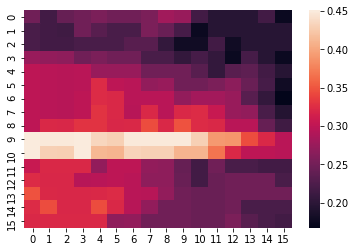

In [11]:
sns.heatmap(data_x[65, 0, :, :, 10])

In [12]:
from scipy.ndimage import median_filter
from skimage.transform import resize
for sample in tnrange(0, len(data_x)):
    filtered = median_filter(data_x[sample, 0, :, :, 10], size = 5)
    filtered = np.reshape(filtered, (8, 2, 8, 2))
    filtered = np.mean(filtered, axis = (1, 3))
    filtered = resize(filtered, (16, 16), 0)
    data_x[sample, :, :, :, 10] = np.stack([filtered] * 24)
    
#data_x = np.delete(data_x, 10, -1)
print(data_x.shape)


(2992, 24, 16, 16, 16)


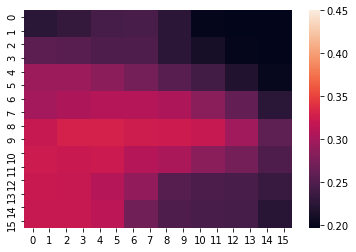

In [13]:
sns.heatmap(data_x[65, 0, :, :, 10], vmax = 0.45)

# Data preprocessing

*  Identify and remove samples with time steps / channels that have a 0. or 1. value, which indicates missing data
*  Identify and remove samples with time steps / channels with no variation, which indicates missing data
*  Identify and remove samples with values above or below the allowable values for the band
*  Identify and remove samples with null data, or samples with extreme band 0 data (which squash all the "clean" samples)
*  Smooth per-pixel temporal data with Whittaker smoother, d = 2, lambda = 0.5 to reduce sample noise

In [14]:
below_1 = [i for i, val in enumerate(data_x[:, :, :, :, :-2]) if np.min(val) < -1.5]
above_1 = [i for i, val in enumerate(data_x[:, :, :, :, :-2]) if np.max(val) > 1.5]
min_vals = [np.min(val) for i, val in enumerate(data_x[:, :, :, :, :-2]) if np.min(val) < -1.5]
max_vals = [np.max(val) for i, val in enumerate(data_x[:, :, :, :, :-2]) if np.max(val) > 1.5]
nans = [i for i, val in enumerate(data_x) if np.sum(np.isnan(val)) > 0]
oob_vals = [i for i, val in enumerate(data_x) if np.max(val[:, :, :, 0]) > 0.7]
print(oob_vals)

outliers = below_1 + above_1 + nans + oob_vals
outliers = list(set(outliers))
print("The outliers are: {}, totalling {}".format(outliers, len(outliers)))
print("\n")
print(min_vals, max_vals)
data_x = data_x[[x for x in range(0, len(data_x)) if x not in outliers]]
data_y = data_y[[x for x in range(0, len(data_y)) if x not in outliers]]
lengths = lengths[[x for x in range(0, len(lengths)) if x not in outliers]]

[]
The outliers are: [2065], totalling 1


[] [1.5207762]


## Temporal Smoothing

In [15]:
high_treecover = np.argwhere(np.sum(data_y, axis = (1, 2)) < 100)
high_treecover = np.delete(data_x, high_treecover, 0)

low_treecover = np.argwhere(np.sum(data_y, axis = (1, 2)) != 0)
low_treecover = np.delete(data_x, low_treecover, 0)

high_scatter = np.std(high_treecover, axis = (0, 2, 3))
low_scatter = np.std(low_treecover, axis = (0, 2, 3))

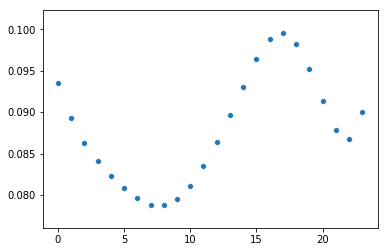

In [16]:
sns.scatterplot(y = low_scatter[:, 12], x = [x for x in range(24)])

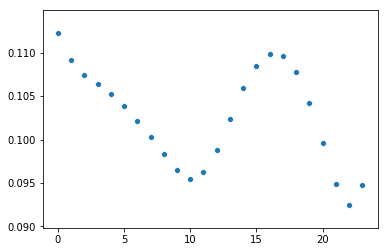

In [17]:
#y_scatter = np.mean(data_x[7, :, :, :, -4], axis = (1, 2))
sns.scatterplot(y = high_scatter[:, 12], x = [x for x in range(24)])

In [18]:
min_all = [0.020040314197540283,
 0.03779078230261802,
 0.02247982447966933,
 0.08546566016972065,
 0.05649614658206701,
 0.07738777950406074,
 0.08403316140174866,
 0.08620105028152465,
 0.07060791917145252,
 0.04271222352981567,
 0.0,
 0.006535016158595681,
 -0.017443332243710755,
 0.0052022112067788805,
 0.006300000008195639,
 4.999999873689376e-05]

max_all = [0.18134751692414286,
 0.27379965722560895,
 0.4014381766319275,
 0.4868380895256996,
 0.4508255499601366,
 0.4679930207133294,
 0.49492222040891654,
 0.5116682988405228,
 0.6329019916057588,
 0.5592091763019562,
 0.3618817925453186,
 0.6979670864343643,
 0.3965773367881775,
 0.6339002758264543,
 0.8166999816894531,
 0.1442749947309494]



#min_all = []
#max_all = []

for band in range(0, data_x.shape[-1]):
    print(band)
    #mins = np.percentile(data_x[:, :, :, :, band], 1)
   # maxs = np.percentile(data_x[:, :, :, :, band], 99)
    #mins, maxs = (np.min(data_x[:, :, :, :, band]), np.max(data_x[:, :, :, :, band]))
    mins = min_all[band]
    maxs = max_all[band]
    data_x[:, :, :, :, band] = np.clip(data_x[:, :, :, :, band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (data_x[:, :, :, :, band] - midrange) / (rng / 2)
    data_x[:, :, :, :, band] = standardized
    
    #min_all.append(mins)
    #max_all.append(maxs)
    
print("The data has been scaled to [{}, {}]".format(np.min(data_x), np.max(data_x)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
The data has been scaled to [-1.0000001192092896, 1.0000001192092896]


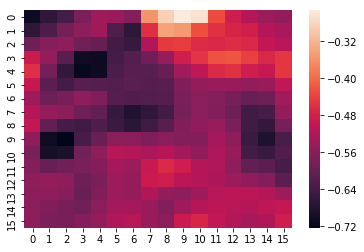

In [19]:
sns.heatmap(data_x[12, 5, :, :, 6])

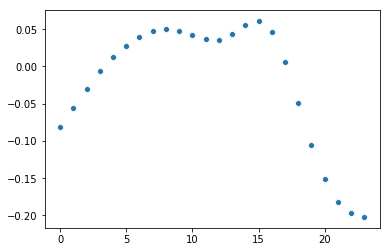

In [20]:
sns.scatterplot(y = data_x[105, :, 15, 14, 3], x = [x for x in range(24)])

# Augment training data

Horizontal and vertical flips for 4x augmentation.

**To do**
*  Random guassian noise
*  Brightness, contrast
*  Region swaps (randomply position positive samples at different locations)

In [21]:
data_x_augmented = []
data_y_augmented = []
lengths_augmented = []

for i, val in enumerate([x for x in range(len(data_x))]):
    data_x_augmented.append(data_x[val])
    data_y_augmented.append(data_y[val])
    lengths_augmented.append(data_x[val].shape[0])
    
    x1 = np.flip(data_x[val], 1)
    y1 = np.flip(data_y[val], 0)
    lengths_augmented.append(x1.shape[0])
    data_x_augmented.append(x1)
    data_y_augmented.append(y1)
    
    x1 = np.flip(data_x[val], [2, 1])
    y1 = np.flip(data_y[val], [1, 0])
    lengths_augmented.append(x1.shape[0])
    data_x_augmented.append(x1)
    data_y_augmented.append(y1)
    
    x1 = np.flip(data_x[val], 2)
    y1 = np.flip(data_y[val], 1)
    lengths_augmented.append(x1.shape[0])
    data_x_augmented.append(x1)
    data_y_augmented.append(y1)

train_x = np.stack(data_x_augmented)
train_y = np.stack(data_y_augmented)
train_y = np.reshape(train_y, (train_y.shape[0], 14, 14, 1))
train_l = np.stack(lengths_augmented)
train_l = np.reshape(train_l, (train_y.shape[0], 1))

In [22]:
test_x = np.load("../tile_data/processed/test_x_l2a_processed.npy")
test_y = np.load("../tile_data/processed/test_y_l2a_processed.npy")
test_lengths = np.load("../tile_data/processed/test_length_l2a_processed.npy")

test_x = np.delete(test_x, 14, -1)
#test_x = np.delete(test_x, 13, -1)


below_1 = [i for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.min(val) < -1.5]
above_1 = [i for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.max(val) > 1.5]
min_vals = [np.min(val) for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.min(val) < -1.5]
max_vals = [np.max(val) for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.max(val) > 1.5]
nans = [i for i, val in enumerate(test_x) if np.sum(np.isnan(val)) > 0]
outliers = below_1 + above_1 + nans
outliers = list(set(outliers))
print("The outliers are: {}, totalling {}".format(outliers, len(outliers)))
print("\n")
print(min_vals, max_vals)

for i in range(len(test_x)):
    mins = np.min(test_x[i, :, :, :, :])
    maxs = np.max(test_x[i, :, :, :, :])
    if mins < -1 or maxs > 1:
        offender_max = np.argmax(np.max(test_x[i, :, :, :, :], (0, 1, 2)), -1)
        offender_min = np.argmin(np.min(test_x[i, :, :, :, :], (0, 1, 2)), -1)
        
        print("{} Offender max/min: {} {}".format(i, offender_max, offender_min))
test_x = test_x[[x for x in range(0, len(test_x)) if x not in outliers]]
test_y = test_y[[x for x in range(0, len(test_y)) if x not in outliers]]
test_lengths = test_lengths[[x for x in range(0, len(test_lengths)) if x not in outliers]]

for sample in tnrange(0, len(test_x)):
    filtered = median_filter(test_x[sample, 0, :, :, 10], size = 5)
    filtered = np.reshape(filtered, (8, 2, 8, 2))
    filtered = np.mean(filtered, axis = (1, 3))
    filtered = resize(filtered, (16, 16), 0)
    test_x[sample, :, :, :, 10] = np.stack([filtered] * 24)

#test_x = np.delete(test_x, 10, -1)
    
for band in range(0, test_x.shape[-1]):
    mins = min_all[band]
    maxs = max_all[band]
    test_x[:, :, :, :, band] = np.clip(test_x[:, :, :, :, band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (test_x[:, :, :, :, band] - midrange) / (rng / 2)
    test_x[:, :, :, :, band] = standardized
    
    
print("The data has been scaled to [{}, {}]".format(np.min(test_x), np.max(test_x)))
print(test_x.shape)

The outliers are: [], totalling 0


[] []
0 Offender max/min: 14 12
6 Offender max/min: 14 12
7 Offender max/min: 14 15
9 Offender max/min: 14 10
12 Offender max/min: 14 12
15 Offender max/min: 14 12
16 Offender max/min: 14 12
17 Offender max/min: 14 10
19 Offender max/min: 14 12
21 Offender max/min: 14 12
23 Offender max/min: 14 12
33 Offender max/min: 14 10
36 Offender max/min: 14 12
40 Offender max/min: 14 12
42 Offender max/min: 14 10
46 Offender max/min: 14 10
49 Offender max/min: 14 12
53 Offender max/min: 14 12
54 Offender max/min: 14 10
55 Offender max/min: 14 12
56 Offender max/min: 14 12
60 Offender max/min: 14 12
63 Offender max/min: 14 12
65 Offender max/min: 14 12
70 Offender max/min: 14 12
71 Offender max/min: 14 12
72 Offender max/min: 14 12
75 Offender max/min: 14 10
79 Offender max/min: 14 12
80 Offender max/min: 14 10
81 Offender max/min: 14 10
83 Offender max/min: 14 12
98 Offender max/min: 14 12
103 Offender max/min: 14 10
104 Offender max/min: 14 12
107 Offender ma


The data has been scaled to [-1.0000001192092896, 1.0000001192092896]
(450, 24, 16, 16, 16)


In [23]:
print("Train and test characteristics:")
print("Train mean Y {}".format(np.mean([np.sum(x) for x in test_y])))
#print("Test mean Y {}".format(np.mean([np.sum(x) for x in data_y[test_ids]])))
#print("Train STD Y {}".format(np.std([np.sum(x) for x in data_y[train_ids]])))
print("Test STD Y {}".format(np.std([np.sum(x) for x in test_y])))
#print("Train number with zero trees {}".format(0.2*len([x for x in data_y[train_ids] if np.sum(x) == 0])))
#print("Test number with zero trees {}".format(0.8*len([x for x in data_y[test_ids] if np.sum(x) == 0])))
print("Train mean NDVI")
print("Test mean NDVI")
#print("There are {} train and {} test samples".format(len(train_ids), len(test_ids)))
#print("There is {} overlap between train and test".format(len([x for x in train_ids if x in test_ids])))

Train and test characteristics:
Train mean Y 54.568888888888885
Test STD Y 68.71730114420392
Train mean NDVI
Test mean NDVI



# Loss definition

The current best loss is a combination of weighted binary cross entropy and per-image Lovasz-Softmax, with a loss schedule with the latter becoming more important each epoch

In [24]:
from keras.losses import binary_crossentropy
import math
from scipy.ndimage import distance_transform_edt as distance

def weighted_bce_loss(y_true, y_pred, weight, smooth = 0.025):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    y_true = K.clip(y_true, smooth, 1. - smooth)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = tf.nn.weighted_cross_entropy_with_logits(
        y_true,
        logit_y_pred,
        weight,
    )
    return tf.reduce_mean(loss)

def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res

def calc_dist_map_batch(y_true):
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)

def surface_loss(y_true, y_pred):
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    return K.mean(multipled)

def bce_loss(y_true, y_pred, smooth = 0.05, mask = None):
    bce = weighted_bce_loss(y_true, y_pred, 1.4, smooth)
    return bce

def finetune_loss(y_true, y_pred):
    lv = lovasz_softmax(y_pred, tf.reshape(y_true, (-1, 14, 14)), classes=[1], per_image=True)
    return lv

def bce_lv(y_true, y_pred, alpha, smooth = 0.025, mask = None, ):
    bce =  weighted_bce_loss(y_true, y_pred, 1.4, smooth = smooth)
    #surf = surface_loss(y_true, y_pred)
    lv = lovasz_softmax(y_pred, tf.reshape(y_true, (-1, 14, 14)), classes=[1], per_image=True)
    #global_loss = (1 - alpha) * ((1-alpha)*bce + alpha*lv)
    #regional_loss = alpha * surf
    #return lv
    return ( (1-alpha)*bce + (alpha * lv) )#global_loss #+ regional_loss

countries = {'ethiopia': [0, 112], 'kenya': [113, 201], 'ghana': [202, 271], 'africaeast': [272, 306],
             'india': [307, 357], 'lac': [358, 398], 'africawest': [399, 449],
 'all': [0, 430]}

#! Move to a src.py
def calculate_metrics(country):
    start_idx = countries[country][0]
    stop_idx = countries[country][1]
    best_f1 = 0
    best_thresh = 0
    p = 0
    r = 0
    error = 0
    ys = []
    vls = []
    t_alls = []
    test_ids = [x for x in range(len(test_x))]
    for test_sample in test_ids[start_idx:stop_idx]:
        y, vl = sess.run([fm, test_loss], feed_dict={inp: test_x[test_sample].reshape(1, 24, 16, 16, n_bands),
                                          length: test_lengths[test_sample].reshape(1, 1),
                                          is_training: False,
                                          labels: test_y[test_sample, :, :].reshape(1, 14, 14),
                                          })
        ys.append(y.reshape((14, 14)))
        vls.append(vl)
        t = test_y[test_sample].reshape((14, 14))
        t_alls.append(t)
    to_remove = np.argwhere(vls > np.percentile(vls, 96))
    #print(to_remove)
    ys = list(np.delete(np.array(ys), to_remove, 0))
    t_alls = list(np.delete(np.array(t_alls), to_remove, 0))
    for thresh in range(7, 13):
        tps = []
        fps = []
        fns = []
        perc_error_20 = []
        perc_error_100 = []
        perc_error_196 = []
        trues = []
        preds = []
        val_loss = []
        for sample in range(len(ys)):
            pred = np.copy(ys[sample])
            true = t_alls[sample]
            vl = vls[sample]
            pred[np.where(pred > thresh*0.05)] = 1
            pred[np.where(pred < thresh*0.05)] = 0
            true_s = np.sum(true)
            pred_s = np.sum(pred)
            p_error = np.around(((abs(pred_s - true_s))/196), 3)
            if true_s < 20:
                perc_error_20.append(p_error)
            elif true_s < 100:
                perc_error_100.append(p_error)
            else:
                perc_error_196.append(p_error)

            #perc_error.append(abs(pred_s - true_s))
            tp, fp, fn = thirty_meter(true, pred)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            trues.append(true_s)
            preds.append(pred_s)
            val_loss.append(np.mean(vl))
        oa_error = abs(np.sum(preds) - np.sum(trues)) / np.sum(trues)
        precision = np.sum(tps) / (np.sum(tps) + np.sum(fps))
        recall = np.sum(tps) / (np.sum(tps) + np.sum(fns))
        f1 = 2*((precision* recall) / (precision + recall))
        if f1 > best_f1:
            best_f1 = f1
            p = precision
            r = recall
            error = oa_error
            best_thresh = thresh*0.05
    print("{}: Val loss: {} Thresh: {} F1: {} Recall: {} Precision: {} Error: {}".format(country, np.around(np.mean(val_loss), 3), np.around(best_thresh, 2),
                                                                                     np.around(best_f1, 3), np.around(p, 3), np.around(r, 3), 
                                                                                     np.around(error, 3)))
    return best_f1

In [25]:
sums = np.sum(train_y, axis = (1, 2))
percents = [np.percentile(sums, x) for x in range(3*10, 100, 10)]
print(percents)

[8.0, 14.0, 23.0, 34.0, 51.0, 91.0, 174.0]


# Equibatch creation

In [26]:
train_ids = [x for x in range(0, len(train_y))]
print(len(train_ids))

def multiplot(matrices):
    '''Plot multiple heatmaps with subplots'''
    fig, axs = plt.subplots(ncols=4)
    fig.set_size_inches(20, 4)
    for i, matrix in enumerate(matrices):
        sns.heatmap(data = matrix, ax = axs[i], vmin = 0, vmax = 0.9)
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
        axs[i].set_yticks([])
        axs[i].set_xticks([])
    plt.show()

print(percents)
def equibatch(train_ids, p = percents, lovasz = False):
    percents = [8.0, 14.0, 23.0, 33.0, 50.0, 78.0, 145.0]
    #percents = [18.0, 25.0, 35.0, 63.0, 149.0, 192.0]
    #percents = [12, 25.0, 54.5, 81.0, 117.0, 185.0] # latin and south america
    #percents = [21.0, 33.0, 52.0, 84.0, 165.0, 189.0] # cocoa ghana
    print(percents)
    np.random.shuffle(train_ids)
    ix = train_ids
    percs = [np.sum(x) for x in train_y[ix]]
    ids0 = [x for x, z in zip(ix, percs) if z == 0]
    ids30 = [x for x, z in zip(ix, percs) if 0 < z < percents[0]]
    ids40 = [x for x, z in zip(ix, percs) if percents[0] < z < percents[1]]
    ids50 = [x for x, z in zip(ix, percs) if percents[1] < z < percents[2]]
    ids60 = [x for x, z in zip(ix, percs) if percents[2] < z < percents[3]]
    ids70 = [x for x, z in zip(ix, percs) if percents[3] < z < percents[4]]
    ids80 = [x for x, z in zip(ix, percs) if percents[4] < z < percents[5]]
    ids90 = [x for x, z in zip(ix, percs) if percents[5] < z < percents[6]]
    ids100 = [x for x, z in zip(ix, percs) if percents[6] < z]
    

    new_batches = []
    maxes = [len(ids0), len(ids30), len(ids40), len(ids50), len(ids60), len(ids70),
             len(ids80), len(ids90), len(ids100)]
    print(maxes)
    cur_ids = [0] * len(maxes)
    iter_len = len(train_ids)//(len(maxes)+1)
    for i in range(0, iter_len):
        for i, val in enumerate(cur_ids):
            if val > maxes[i] - 1:
                cur_ids[i] = 0
        if cur_ids[0] >= (maxes[0] - 2):
            cur_ids[0] = 0
        to_append = [ids0[cur_ids[0]], ids0[cur_ids[0] + 1], ids30[cur_ids[1]], ids40[cur_ids[2]],
                    ids50[cur_ids[3]],
                    ids60[cur_ids[4]], ids70[cur_ids[5]], ids80[cur_ids[6]],
                    ids90[cur_ids[7]], ids100[cur_ids[8]]]
        
        np.random.shuffle(to_append)
        new_batches.append(to_append)
        cur_ids = [x + 1 for x in cur_ids]
        cur_ids[0] += 1
        
    new_batches = [item for sublist in new_batches for item in sublist]
    #overlap = [x for x in new_batches if x in test_ids]
    #print("There is {} overlap. Error if > 0".format(len(overlap)))
    return new_batches

batch = equibatch(train_ids)

11964
[8.0, 14.0, 23.0, 34.0, 51.0, 91.0, 174.0]
[8.0, 14.0, 23.0, 33.0, 50.0, 78.0, 145.0]
[1988, 1572, 896, 1116, 992, 1152, 976, 912, 1684]


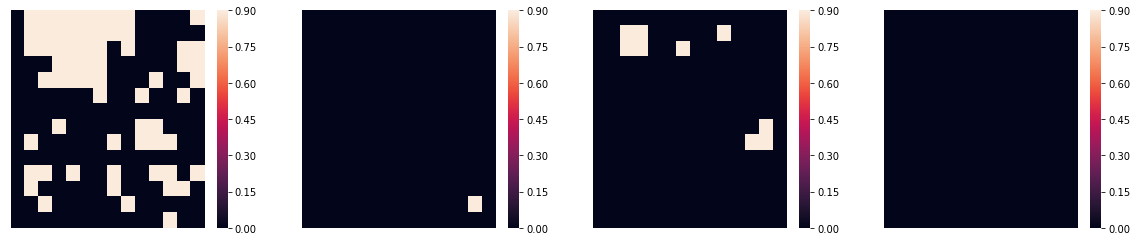

In [27]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[4:8]]])

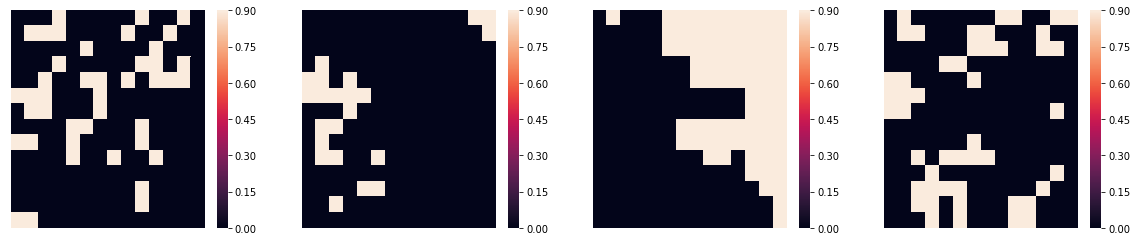

In [28]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[8:12]]])

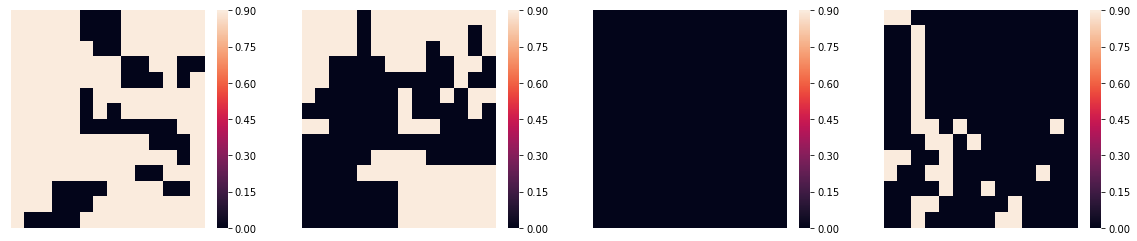

In [29]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[0:4]]])

# Graph set up

In [30]:
FRESH_START = True
best_val = 0.65

START_EPOCH = 1
END_EPOCH = 150
LEARNING_RATE = 3e-3
test_ids = [x for x in range(0, len(test_x))]

print("The model does not overfit after 100 epochs from 5e-4 to 1e-1")
print("We still need to figure out whether or not to use lovasz for finetune")
print("Starting model with: \n {} zone out \n {} l2 \n {} initial LR \n {} final LR \n {} parameters"
     .format(ZONE_OUT_PROB, L2_REG, INITIAL_LR, FINAL_LR, total_parameters))

if not FRESH_START:
    print("Resuming training with a best validation score of {}".format(best_val))
    
if FRESH_START:
    print("Restarting training from scratch on {} "
          "train and {} test samples, total {}".format(len(train_ids), len(test_ids), len(train_ids)/4))

    #optimizer = tf.train.AdamOptimizer(LEARNING_RATE, epsilon = 1e-8)
    optimizer = AdaBoundOptimizer(1e-3, 1e-1)
    train_loss = bce_lv(tf.reshape(labels, (-1, 14, 14, 1)), fm, alpha = alpha)
    #l2_loss = tf.losses.get_regularization_l05oss()
    #train_loss += l2_loss

    ft_optimizer = tf.train.GradientDescentOptimizer(0.01)
    ft_loss = finetune_loss(tf.reshape(labels, (-1, 14, 14, 1)), fm)
    #wu_loss = weighted_bce_loss(tf.reshape(labels, (-1, 14, 14, 1)), fm, weight = 1.5)
    
    test_loss = weighted_bce_loss(tf.reshape(labels, (-1, 14, 14, 1)), fm, weight = 1.)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(train_loss)   
        #ft_op = ft_optimizer.minimize(ft_loss)
        ft_op = ft_optimizer.minimize(train_loss)
        
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    saver = tf.train.Saver(max_to_keep = 2)
    
print("The graph has been finalized")

The model does not overfit after 100 epochs from 5e-4 to 1e-1
We still need to figure out whether or not to use lovasz for finetune
Starting model with: 
 0.3 zone out 
 0.0 l2 
 0.0002 initial LR 
 0.001 final LR 
 241621 parameters
Restarting training from scratch on 11964 train and 450 test samples, total 2991.0
()
()
The graph has been finalized


In [31]:
# This cell should be run to do fine-tuning, if commented - train from scratch

new_saver = tf.train.import_meta_graph('../models/february-fused-master-39-83/model.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('../models/february-fused-master-39-83'))

INFO:tensorflow:Restoring parameters from ../models/february-fused-master-39-83/model


In [32]:
from time import sleep
best_val = 0.823

train_ids = [x for x in range(len(train_y))]

for i in range(39, 100):
    #al = np.min([i*0.01, 0.20])
    #al = 0.
    al = min(i*0.02, 0.05)
    #randomize = train_ids
    #np.random.shuffle(randomize)
    randomize = equibatch(train_ids)
    #print("Loss: {} 1.5 weighted BCE + {} Image Lovasz".format( (0.95-al), (0.05 + al)))
    #op = train_op
    #loss = train_loss
    op = train_op
    loss = train_loss
    BATCH_SIZE = 20
    test_ids = [x for x in range(0, len(test_x))]
    losses = []
    
    for k in tnrange(int(len(randomize) // BATCH_SIZE)):
        if k % 25 == 0:
            sleep(3)
        batch_ids = randomize[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
        batch_y = train_y[batch_ids, :, :].reshape(len(batch_ids), 14, 14)
        opt, tr = sess.run([op, loss],
                              feed_dict={inp: train_x[batch_ids, :, :, :],
                                         length: train_l[batch_ids].reshape((-1, 1)),
                                         labels: batch_y,
                                         is_training: True,
                                         keep_rate: np.max((1 - (i*0.006), 0.90)),
                                         alpha: al
                                         })
        losses.append(tr)
    
    print("Epoch {}: Loss {}".format(i, np.around(np.mean(losses[:-1]), 3)))
    calculate_metrics('ethiopia')
    calculate_metrics('ghana')
    calculate_metrics('kenya')
    calculate_metrics('lac')
    calculate_metrics('india')
    calculate_metrics('africaeast')
    calculate_metrics('africawest')
    f1 = calculate_metrics('all')
    if f1 > (best_val - 0.01):
        #best_val = f1
        print("Saving model with {}".format(f1))
        os.mkdir("../models/february-fused-master-{}-{}-{}/".format(str(i), str(f1)[:2], str(f1)[3]))
        save_path = saver.save(sess, "../models/february-fused-master-{}-{}-{}/model".format(str(i), str(f1)[:2], str(f1)[3]))
        if f1 > best_val:
            best_val = f1

[8.0, 14.0, 23.0, 33.0, 50.0, 78.0, 145.0]
[1988, 1572, 896, 1116, 992, 1152, 976, 912, 1684]



Epoch 39: Loss 0.40299999713897705
ethiopia: Val loss: 0.32100000977516174 Thresh: 0.55 F1: 0.838 Recall: 0.833 Precision: 0.843 Error: 0.012
ghana: Val loss: 0.33399999141693115 Thresh: 0.6 F1: 0.827 Recall: 0.886 Precision: 0.775 Error: 0.124
kenya: Val loss: 0.3089999854564667 Thresh: 0.5 F1: 0.829 Recall: 0.834 Precision: 0.824 Error: 0.012
lac: Val loss: 0.45100000500679016 Thresh: 0.6 F1: 0.863 Recall: 0.815 Precision: 0.917 Error: 0.125
india: Val loss: 0.30799999833106995 Thresh: 0.55 F1: 0.805 Recall: 0.864 Precision: 0.753 Error: 0.129
africaeast: Val loss: 0.2630000114440918 Thresh: 0.55 F1: 0.928 Recall: 0.95 Precision: 0.907 Error: 0.045
africawest: Val loss: 0.35499998927116394 Thresh: 0.4 F1: 0.792 Recall: 0.81 Precision: 0.775 Error: 0.043
all: Val loss: 0.328000009059906 Thresh: 0.55 F1: 0.841 Recall: 0.851 Precision: 0.83 Error: 0.025
Saving model with 0.8406363636363637


FileNotFoundError: [Errno 2] No such file or directory: '../models/february-fused-master-39-0.8406363636363637/model'

In [37]:
f1 = 85.1
i = 51
os.mkdir("../models/february-fused-master-{}-{}-{}/".format(str(i), str(f1)[:2], str(f1)[3]))
#os.mkdir("../models/february-fused-master-40-84-1/")
#save_path = saver.save(sess, "../models/february-fused-master-40-84-1/model")

In [ ]:
# master-39-83
# ETH 84, GHA 79, KEN 80, LAC 87, IND 81, AF E 93, AF W 77

In [78]:
calculate_metrics('ethiopia')
calculate_metrics('ghana')
calculate_metrics('kenya')
calculate_metrics('lac')
calculate_metrics('india')
calculate_metrics('africaeast')
calculate_metrics('africawest')
calculate_metrics('all')

ethiopia: Val loss: 0.3009999990463257 Thresh: 0.5 F1: 0.837 Recall: 0.844 Precision: 0.829 Error: 0.018
ghana: Val loss: 0.3400000035762787 Thresh: 0.4 F1: 0.787 Recall: 0.811 Precision: 0.764 Error: 0.058
kenya: Val loss: 0.33899998664855957 Thresh: 0.35 F1: 0.794 Recall: 0.781 Precision: 0.807 Error: 0.033
lac: Val loss: 0.382999986410141 Thresh: 0.6 F1: 0.874 Recall: 0.886 Precision: 0.863 Error: 0.026
india: Val loss: 0.3059999942779541 Thresh: 0.55 F1: 0.806 Recall: 0.882 Precision: 0.742 Error: 0.159
africaeast: Val loss: 0.2750000059604645 Thresh: 0.45 F1: 0.931 Recall: 0.959 Precision: 0.904 Error: 0.058
africawest: Val loss: 0.39100000262260437 Thresh: 0.35 F1: 0.769 Recall: 0.813 Precision: 0.729 Error: 0.103
all: Val loss: 0.3230000138282776 Thresh: 0.45 F1: 0.83 Recall: 0.837 Precision: 0.823 Error: 0.017


0.8301789441591031

In [277]:
# potential problem test IDS: 135505813, 135505835, 
save_path = saver.save(sess, "../models/february-fused-master-/model")


# Model validation and sanity checks





In [39]:
start = 0
test_ids = [x for x in range(0, len(test_x))]

def multiplot(matrices, nrows = 2, ncols = 4):
    ''
    'Plot multipleheatmaps with subplots'''
    fig, axs = plt.subplots(ncols=4, nrows = nrows)
    fig.set_size_inches(20, 4*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i, matrix in enumerate(matrices[min_i:max_i]):
            sns.heatmap(data = matrix, ax = axs[r - 1, i], vmin = 0, vmax = 0.9)
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
    plt.show
start = 0

In [40]:
def identify_alignment(true, pred, wsize = 3):
    n_single_trees = 0
    for x in range(1, true.shape[0] - 1, 1):
        for y in range(1, true.shape[1] - 1, 1):
            wind_true = true[x-1:x+2, y-1:y+2]
            wind_pred = pred[x-1:x+2, y-1:y+2]
            if wind_true[1, 1] == 1:
                if np.sum(wind_true) == 1:
                    n_single_trees += 1
                    pred_place = np.argmax(wind_pred.flatten())
                    diff = wind_pred.flatten()[pred_place] - wind_pred.flatten()[4]
                    if pred_place != 4:
                        if diff > 0.2:
                            x_lv = pred_place // 3
                            y_lv = pred_place % 3
                            print(x_lv, y_lv)
                            proposed = wind_true[x_lv - 1:x_lv+2, y_lv-1:y_lv+2]
                            if np.sum(proposed) == 0:
                                print("There is a missed position at {} x, {} y: {}".format(x, y, diff))

0.4622222222222222
208
209
210
211
212
213
2 2
214
215
2 2


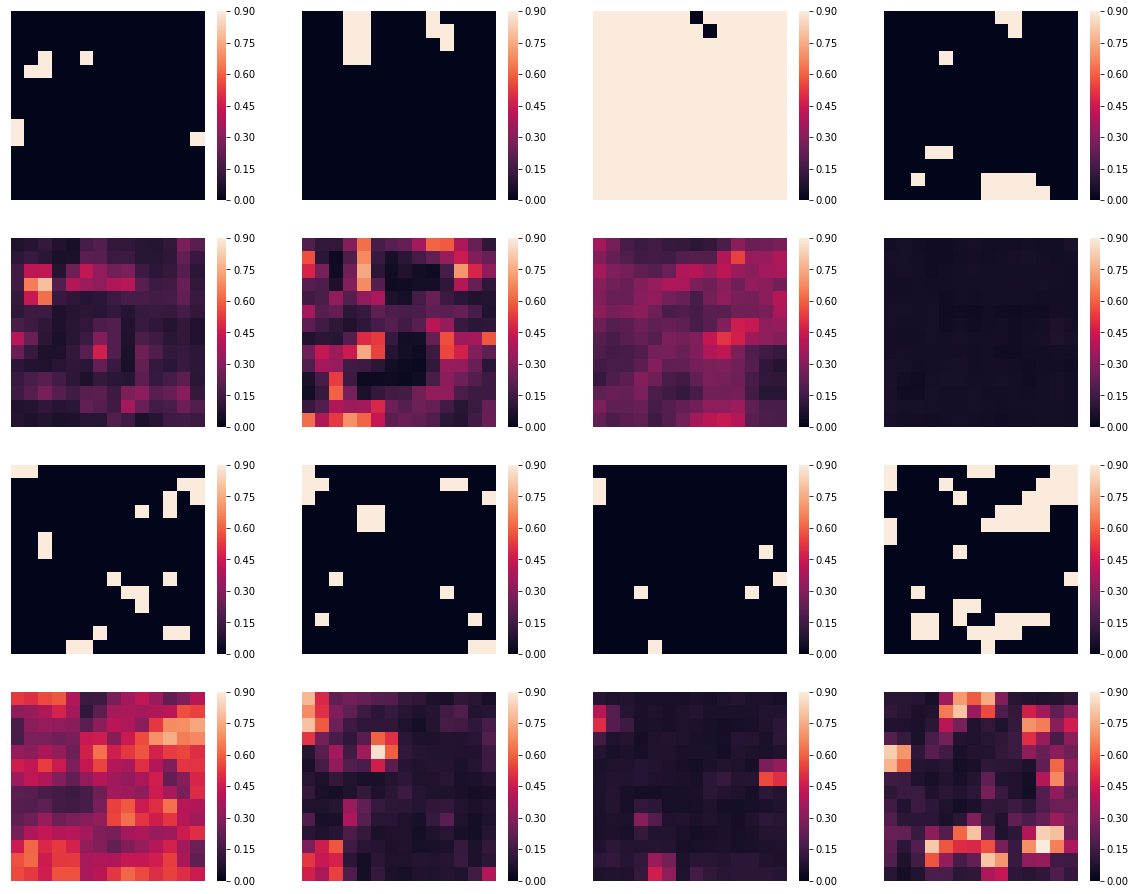

In [67]:
test_losses = []
print(start/len(test_ids))
test_ids = sorted(test_ids)
matrix_ids = [test_ids[start], test_ids[start + 1], test_ids[start + 2], test_ids[start + 3],
              test_ids[start + 4], test_ids[start + 5], test_ids[start + 6], test_ids[start + 7]]
#matrix_ids = random.sample(test_ids, 4)z

preds = []
trues = []
for i in matrix_ids:
    idx = i
    print(i)
    y = sess.run([fm], feed_dict={inp: test_x[idx].reshape(1, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands),
                                  length: test_lengths[idx].reshape(1, 1),
                                  is_training: False,
                                  })
    y = np.array(y).reshape(14, 14)
    #y[np.where(y > 0.7)] = 0.85
    preds.append(y)
    true = test_y[idx].reshape(14, 14)
    identify_alignment(true, y)
    trues.append(true)
    
    
""


to_plot = trues[0:4] + preds[0:4] + trues[4:] + preds[4:]

multiplot(to_plot, nrows = 4, ncols = 4)

start = start + 8

In [242]:
train_ids = [x for x in range(train_x.shape[0])]
start = 1110*4

1119


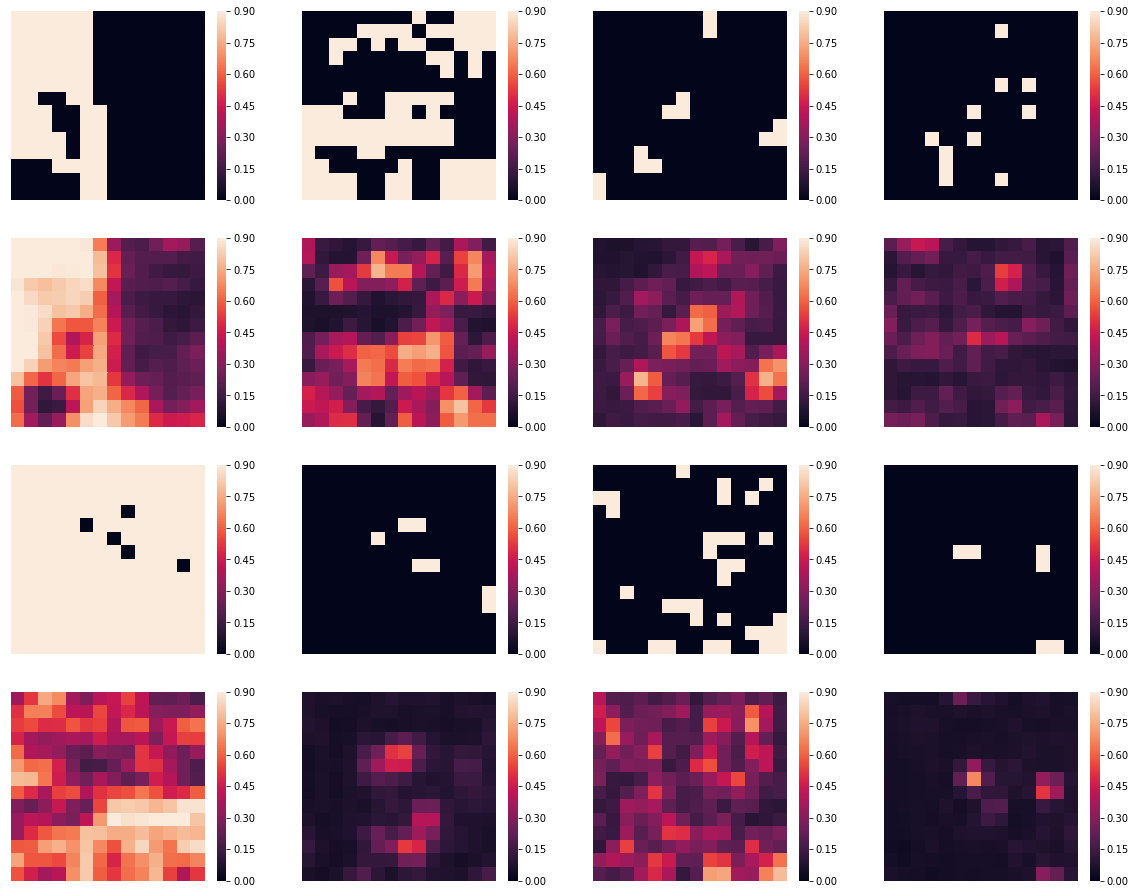

In [244]:
# 127, 143, 238, 241, 242, 252, 264, 282, 288, 318
test_losses = []
train_ids = sorted(train_ids)
#matrix_ids = random.sample(755, 4)
matrix_ids = [train_ids[start], train_ids[start + 4], train_ids[start + 8], train_ids[start + 12], train_ids[start + 16],
             train_ids[start + 20], train_ids[start + 24], train_ids[start + 28], train_ids[start + 32]]

#matrix_ids = [722*4, 751*4, 761*4, 762*4]
#matrix_ids = [len(train_x)-28]

preds = []
trues = []
print(start//4)
for i in matrix_ids:
    idx = i
    y = sess.run([fm], feed_dict={inp: train_x[idx].reshape(1, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands),
                                  length: train_l[idx].reshape(1, 1),
                                  is_training: False,
                                  })
    y = np.array(y).reshape(14, 14)
    #y[np.where(y > 0.3)] = 0.85
    preds.append(y)
    true = train_y[idx].reshape(14, 14)
    #identify_alignment(true, y)
    trues.append(true)
    
start += 36
# 20, 
    

to_plot = trues[0:4] + preds[0:4] + trues[5:] + preds[5:]
multiplot(to_plot, nrows = 4, ncols = 4)  

## TODO @jombrandt top 10 worst training, test samples by IOU 

These should be written to a tmp/ .txt file and indexed by validate-data.ipynb to ensure that original classifications were correct, and to identify regions that need more training data.

In [ ]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

In [ ]:
cross_entropy(np.array([[.01], [0.01]]), np.array([[.04], [0.04]]))